# PII Masking with NER Using RoBERTa and BERT

A comparative analysis of Personally Identifiable Information (PII) Masking using NER models BERT and RoBERTa against Microsoft's [Presidio](https://github.com/microsoft/presidio).

BERT and RoBERTa are models deisigned for masked language modeling and next sentence prediction. Thus, they will be fine-tuned for the NER task of identifying (and masking) PII in the English language.

### Setup

Installing required libraries and loading the [PII-Masking-300k](https://huggingface.co/datasets/ai4privacy/pii-masking-300k) dataset from Hugging Face.

In [ ]:
!pip install datasets transformers torch

import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from transformers import BertTokenizer, BertConfig, BertForTokenClassification
from transformers import RobertaTokenizer, RobertaConfig, RobertaForTokenClassification
from functools import reduce

LANGUAGE = 'English'

dataset = load_dataset('ai4privacy/pii-masking-300k')

df_train = pd.DataFrame(dataset['train'].filter(lambda row: row['language'] == LANGUAGE))
df_test = pd.DataFrame(dataset['validation'].filter(lambda row: row['language'] == LANGUAGE))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/177677 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/47728 [00:00<?, ? examples/s]

Filter:   0%|          | 0/177677 [00:00<?, ? examples/s]

Filter:   0%|          | 0/47728 [00:00<?, ? examples/s]

Using device: cpu


## Exploring the Data

Getting to know the dataset. Its length, features, masking labels, label distribution, etc.

,source_text,target_text,privacy_mask,span_labels,mbert_text_tokens,mbert_bio_labels,id,language,set
0,Subject: Group Messaging for Admissions Proces...,Subject: Group Messaging for Admissions Proces...,"[{'value': 'wynqvrh053', 'start': 287, 'end': ...","[[440, 453, ""USERNAME""], [430, 437, ""TIME""], [...","[Sub, ##ject, :, Group, Mess, ##aging, for, Ad...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",40767A,English,train
1,- Meeting at 2:33 PM\n- N23 - Meeting at 11:29...,- Meeting at [TIME]\n- [USERNAME] - Meeting at...,"[{'value': '2:33 PM', 'start': 13, 'end': 20, ...","[[74, 81, ""TIME""], [50, 60, ""USERNAME""], [40, ...","[-, Meeting, at, 2, :, 33, PM, -, N, ##23, -, ...","[O, O, O, B-TIME, I-TIME, I-TIME, I-TIME, O, O...",40767B,English,train
2,Subject: Admission Notification - Great Britai...,Subject: Admission Notification - Great Britai...,"[{'value': '5:24am', 'start': 263, 'end': 269,...","[[395, 407, ""SOCIALNUMBER""], [358, 375, ""EMAIL...","[Sub, ##ject, :, Ad, ##mission, Not, ##ificati...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",40768A,English,train
3,Card: KB90324ER\n Country: GB\n Building: ...,Card: [IDCARD]\n Country: [COUNTRY]\n Buil...,"[{'value': 'KB90324ER', 'start': 6, 'end': 15,...","[[390, 393, ""STATE""], [368, 378, ""CITY""], [346...","[Card, :, KB, ##90, ##32, ##4, ##ER, \, n, Cou...","[O, O, B-IDCARD, I-IDCARD, I-IDCARD, I-IDCARD,...",40768B,English,train
4,"N, WA14 5RW\n Password: r]iD1#8\n\n...and so...","N, WA14 5RW\n Password: [PASS]\n\n...and so ...","[{'value': 'r]iD1#8', 'start': 26, 'end': 33, ...","[[336, 352, ""DATE""], [26, 33, ""PASS""]]","[N, ,, W, ##A, ##14, 5, ##R, ##W, \, n, Pass, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, B-PASS...",40768C,English,train



Train set size: 29908 // Test set size: 7946


Unique masking labels: {'LASTNAME2', 'LASTNAME3', 'COUNTRY', 'STREET', 'DRIVERLICENSE', 'LASTNAME1', 'DATE', 'CARDISSUER', 'POSTCODE', 'EMAIL', 'TIME', 'USERNAME', 'IP', 'SOCIALNUMBER', 'GIVENNAME1', 'BUILDING', 'TEL', 'SEX', 'CITY', 'SECADDRESS', 'GEOCOORD', 'PASSPORT', 'TITLE', 'IDCARD', 'BOD', 'GIVENNAME2', 'PASS', 'STATE'}



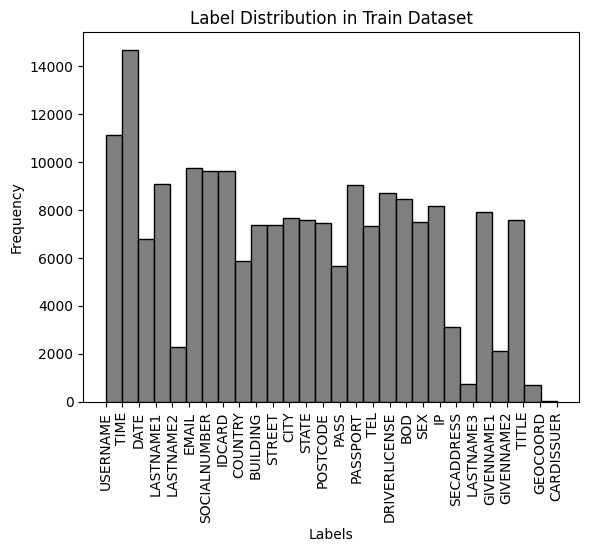


Unique masking labels: {'LASTNAME2', 'LASTNAME3', 'COUNTRY', 'STREET', 'DRIVERLICENSE', 'LASTNAME1', 'DATE', 'CARDISSUER', 'POSTCODE', 'EMAIL', 'IP', 'GIVENNAME1', 'TIME', 'USERNAME', 'SOCIALNUMBER', 'BUILDING', 'TEL', 'SEX', 'CITY', 'SECADDRESS', 'GEOCOORD', 'PASSPORT', 'TITLE', 'IDCARD', 'BOD', 'GIVENNAME2', 'PASS', 'STATE'}



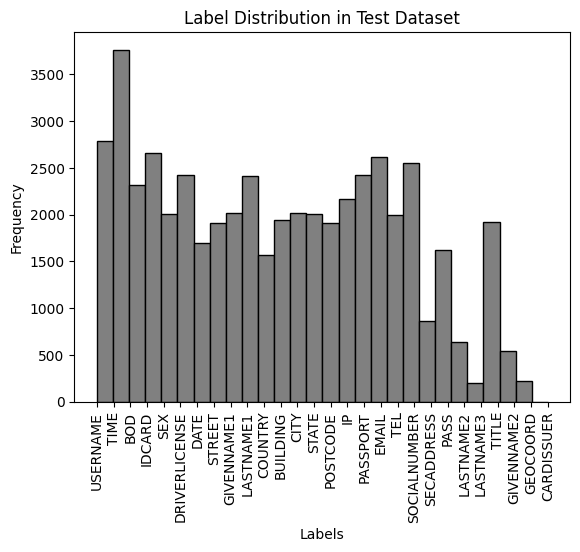

{'BOD',
 'BUILDING',
 'CARDISSUER',
 'CITY',
 'COUNTRY',
 'DATE',
 'DRIVERLICENSE',
 'EMAIL',
 'GEOCOORD',
 'GIVENNAME1',
 'GIVENNAME2',
 'IDCARD',
 'IP',
 'LASTNAME1',
 'LASTNAME2',
 'LASTNAME3',
 'PASS',
 'PASSPORT',
 'POSTCODE',
 'SECADDRESS',
 'SEX',
 'SOCIALNUMBER',
 'STATE',
 'STREET',
 'TEL',
 'TIME',
 'TITLE',
 'USERNAME'}

In [ ]:
display(df_train.head())

print(f'\nTrain set size: {len(df_train)} // Test set size: {len(df_test)}\n')

def analyze_label_distribution(dataset, dataset_name):
  label_rows = map(lambda data: map(lambda mask: mask['label'], data), dataset['privacy_mask'])
  all_labels = [label for labels in label_rows for label in labels]
  unique_labels = set(all_labels)
  print(f'\nUnique masking labels: {unique_labels}\n')

  plt.hist(all_labels, bins=len(unique_labels), color='gray', edgecolor='black')
  plt.xlabel('Labels')
  plt.xticks(rotation='vertical')
  plt.ylabel('Frequency')
  plt.title(f'Label Distribution in {dataset_name} Dataset')
  plt.show()

  return unique_labels

unique_labels = analyze_label_distribution(df_train, 'Train')
analyze_label_distribution(df_test, 'Test')

## TODO: Check whether I should implement a filter to remove underrepresented labels,
## like CARDISSUER and GEOCOORD since they are orders of magnitude inferior in number
## and the model may not have enough data to confidently identify these categories

## Could do this by creating a flat-map of all unique tags on a given text, putting all in a list
## like [USERNAME,NAME,DATE], so I could do a search if the to-exclude tags exist in this new column
## and if yes, remove the row (e.g. filter by that)


# Pre-processing

Mapping labels to IDs, ...

In [ ]:
label2id = {k: v for v, k in enumerate(unique_labels)}
id2label = {v: k for v, k in enumerate(unique_labels)}

print('Mapping of labels to IDs:')
print(label2id)




Mapping of labels to IDs:
{'LASTNAME2': 0, 'LASTNAME3': 1, 'COUNTRY': 2, 'STREET': 3, 'DRIVERLICENSE': 4, 'LASTNAME1': 5, 'DATE': 6, 'CARDISSUER': 7, 'POSTCODE': 8, 'EMAIL': 9, 'TIME': 10, 'USERNAME': 11, 'IP': 12, 'SOCIALNUMBER': 13, 'GIVENNAME1': 14, 'BUILDING': 15, 'TEL': 16, 'SEX': 17, 'CITY': 18, 'SECADDRESS': 19, 'GEOCOORD': 20, 'PASSPORT': 21, 'TITLE': 22, 'IDCARD': 23, 'BOD': 24, 'GIVENNAME2': 25, 'PASS': 26, 'STATE': 27}


# BERT Model

The BERT model to be used is going to be BertForTokenClassification, which is already fine-tuned for the NER task ([doc](https://huggingface.co/docs/transformers/en/model_doc/bert#transformers.BertForTokenClassification)).

The case-sensitive models are being used because personal information dependents a lot on case (e.g.: hunt -> verb, Hunt -> surname).

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
roberta_tokenizer = RobertaTokenizer.from_pretrained('FacebookAI/roberta-base') #RoBERTa base is case-sensitive

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]